In [32]:
import pandas as pd 
import numpy as np
import itertools
import re
import string
pd.set_option('display.max_colwidth', 100)
import nltk.corpus
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
#!pip install contractions
import contractions 
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#!pip install xgboost
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
reviews = pd.read_json(r'C:\Users\dfota\OneDrive\Έγγραφα\Thesis Project\Amazon-Game-Reviews-Analysis\Data\MergedDataset.json')

In [3]:
reviews.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews
0,B00000DMAN,5,"11 28, 1999",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This game is a lot of fun, with a creepy atmosphere that revolves around the disappearance of Ag..."
1,B00000DMAN,4,"03 5, 2003",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was not the best mystery/adventure game I've ever played, and I'm not even a big fan of suc..."
2,B00000DMAN,4,"02 13, 2001",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was a pretty good game, but not a great game. I'd probably rate this closer to 3 1/2 stars...."
3,B00000DMAN,4,"08 19, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,We stopped watching the series (lack of time) and so this was a nice way to keep the excitement...
4,B00000DMAN,5,"07 27, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"As a fan of Myst and Riven, I would not put this game in the same category. However, it does e..."


In [3]:
reviews['rating_class'] = reviews['overall'].apply(lambda x: 'bad' if x < 3 else'good')
reviews.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews,rating_class
0,B00000DMAN,5,"11 28, 1999",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This game is a lot of fun, with a creepy atmosphere that revolves around the disappearance of Ag...",good
1,B00000DMAN,4,"03 5, 2003",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was not the best mystery/adventure game I've ever played, and I'm not even a big fan of suc...",good
2,B00000DMAN,4,"02 13, 2001",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was a pretty good game, but not a great game. I'd probably rate this closer to 3 1/2 stars....",good
3,B00000DMAN,4,"08 19, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,We stopped watching the series (lack of time) and so this was a nice way to keep the excitement...,good
4,B00000DMAN,5,"07 27, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"As a fan of Myst and Riven, I would not put this game in the same category. However, it does e...",good


In [30]:
reviews['rating_class'].value_counts()

1    95521
0    16061
Name: rating_class, dtype: int64

In [5]:
raw_tokens=len([w for t in (reviews["reviews"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))

Number of raw tokens: 21317836


In [6]:
def text_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

In [8]:
def replace_numbers(text):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [9]:
stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [10]:
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

In [11]:
def lemmatize_text(words):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

In [12]:
def normalize_and_lemmatize(input):
    sample = text_cleaning(input)
    sample = expand_contractions(sample)
    words = nltk.word_tokenize(sample)
    words = remove_stopwords(words)    
    lemmas = lemmatize_text(words)
    return ' '.join(lemmas)

In [13]:
reviews['clean_text'] = reviews['reviews'].map(lambda text: normalize_and_lemmatize(text))

In [14]:
clean_tokens=len([w for t in (reviews["clean_text"].apply(word_tokenize)) for w in t])
print('Number of clean tokens: {}\n'.format(clean_tokens))
print('Percentage of removed tokens: {0:.2f}'.format(1-(clean_tokens/raw_tokens)))

Number of clean tokens: 9386880

Percentage of removed tokens: 0.56


In [15]:
def token (text):
    token = [w for w in nltk.word_tokenize(text)]
    return token

reviews['token'] = reviews['clean_text'].apply(token)

In [16]:
reviews.head()

,asin,overall,reviewTime,title,category,imageURLHighRes,reviews,rating_class,clean_text,token
0,B00000DMAN,5,"11 28, 1999",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This game is a lot of fun, with a creepy atmosphere that revolves around the disappearance of Ag...",good,game lot fun creepy atmosphere revolves around disappearance agent mulder scully heard complain ...,"[game, lot, fun, creepy, atmosphere, revolves, around, disappearance, agent, mulder, scully, hea..."
1,B00000DMAN,4,"03 5, 2003",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was not the best mystery/adventure game I've ever played, and I'm not even a big fan of suc...",good,not best mysteryadventure game ever played not even big fan game begin serious xphile despite se...,"[not, best, mysteryadventure, game, ever, played, not, even, big, fan, game, begin, serious, xph..."
2,B00000DMAN,4,"02 13, 2001",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"This was a pretty good game, but not a great game. I'd probably rate this closer to 3 1/2 stars....",good,pretty good game not great game id probably rate closer star agent craig wilmore scully mulder d...,"[pretty, good, game, not, great, game, id, probably, rate, closer, star, agent, craig, wilmore, ..."
3,B00000DMAN,4,"08 19, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,We stopped watching the series (lack of time) and so this was a nice way to keep the excitement...,good,stopped watching series lack time nice way keep excitement going game good perhaps little disori...,"[stopped, watching, series, lack, time, nice, way, keep, excitement, going, game, good, perhaps,..."
4,B00000DMAN,5,"07 27, 2000",The X-Files Game,PC,https://images-na.ssl-images-amazon.com/images/I/31BDm2VqflL.jpg,"As a fan of Myst and Riven, I would not put this game in the same category. However, it does e...",good,fan myst riven would not put game category however equally well type myst riven not main charact...,"[fan, myst, riven, would, not, put, game, category, however, equally, well, type, myst, riven, n..."


In [17]:
reviews['rating_class'] = reviews['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [18]:
X = reviews['clean_text']
y = reviews['rating_class']

In [19]:
#!pip install sklearn
from sklearn.model_selection import train_test_split
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(83686,)
Test Set Shape		:(27896,)


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [22]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

In [23]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1), max_features=10000)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [24]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 10000


In [25]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [26]:
pd.DataFrame(count_vect_train, columns = vocab)

,aa,aaa,abandon,abandoned,ability,abit,able,aboard,abomination,abound,...,zillion,zip,zombie,zombrex,zone,zoning,zoo,zoom,zoomed,zooming
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83682,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score)) 

In [28]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.7549607743649035


In [29]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.15      0.15      4059
           1       0.86      0.86      0.86     23837

    accuracy                           0.76     27896
   macro avg       0.51      0.51      0.51     27896
weighted avg       0.75      0.76      0.75     27896



In [48]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'sag',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

c:\users\dfota\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


f1 score: 0.8931707180702178


In [49]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.57      0.85      0.68      4037
           1       0.97      0.89      0.93     23859

    accuracy                           0.88     27896
   macro avg       0.77      0.87      0.80     27896
weighted avg       0.91      0.88      0.89     27896



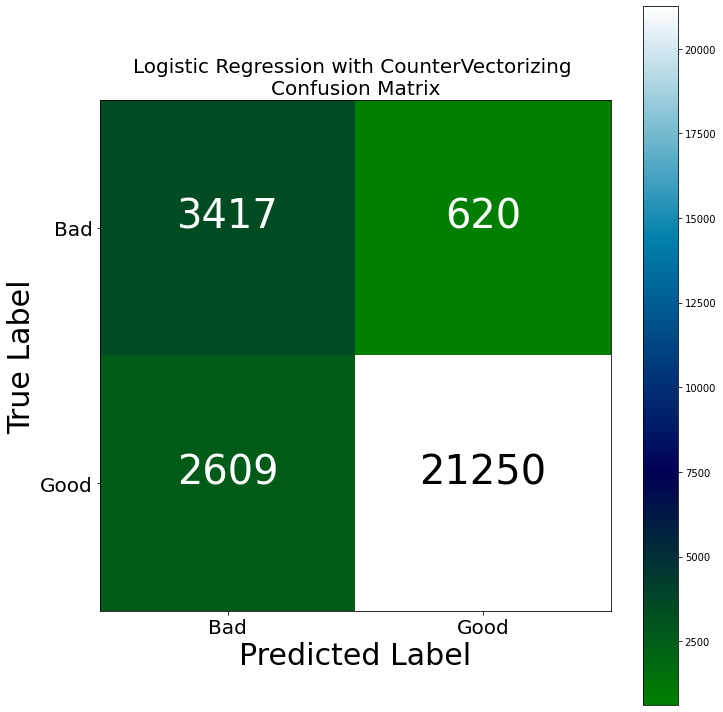

In [50]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

In [31]:
model = LogisticRegression()
parameters = {
    'C' : np.logspace(-3, 7),
    'solver' : ['sag', 'saga']
}

In [34]:
grid_search = GridSearchCV(model, param_grid=parameters, cv=10,verbose = 1, 
                           scoring='accuracy',error_score=0)

In [ ]:
grid_result = grid_search.fit(count_vect_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [45]:
weights = {0:6.0, 1:1.0}
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial',max_iter = 4000, verbose = 1, solver = 'sag',
                                     class_weight = weights, C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 1318 epochs took 11373 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 189.6min finished


f1 score: 0.8977528306119162


In [46]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.59      0.82      0.68      4037
           1       0.97      0.90      0.93     23859

    accuracy                           0.89     27896
   macro avg       0.78      0.86      0.81     27896
weighted avg       0.91      0.89      0.90     27896



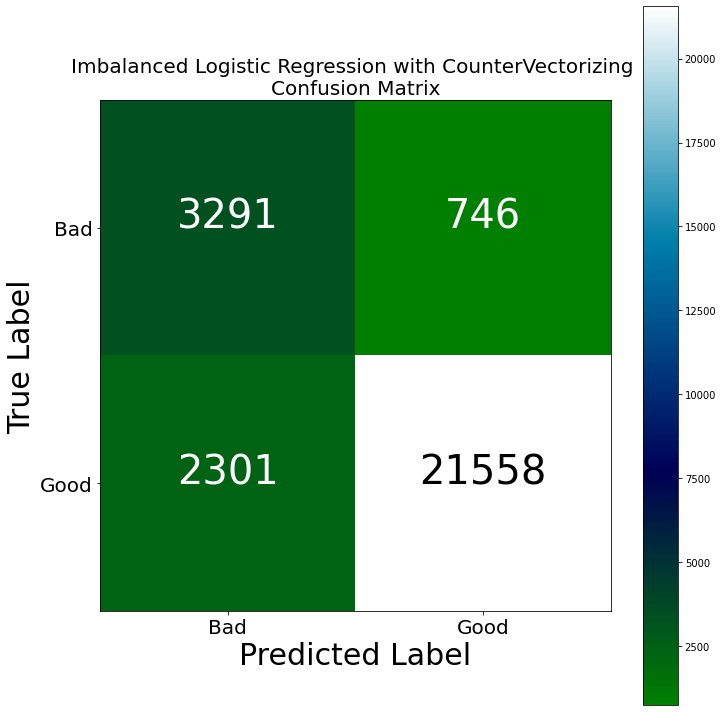

In [47]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Imbalanced Logistic Regression")

In [51]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 100, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8672068215583003


In [52]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.91      0.29      0.43      4037
           1       0.89      1.00      0.94     23859

    accuracy                           0.89     27896
   macro avg       0.90      0.64      0.69     27896
weighted avg       0.89      0.89      0.87     27896



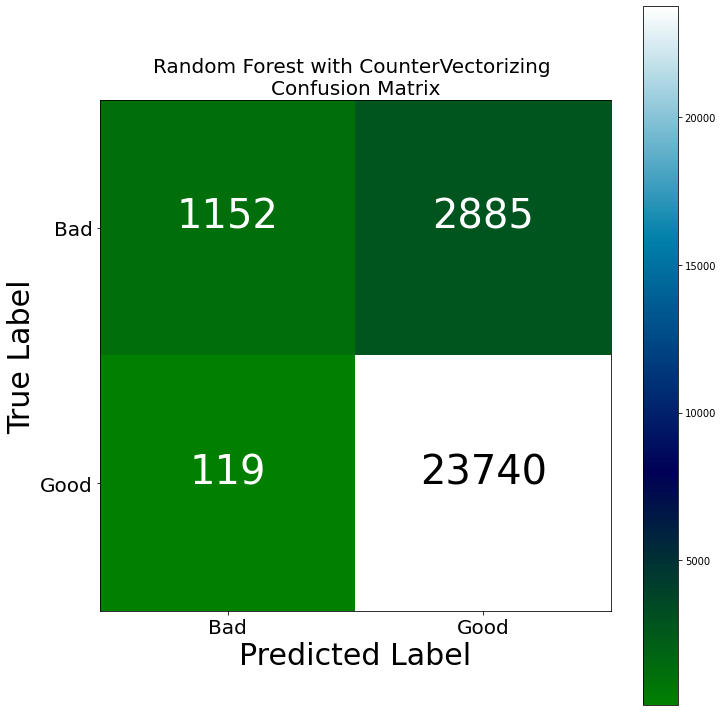

In [53]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

In [68]:
n_estimators = [10, 50, 100]

In [66]:
param_grid = dict(n_estimators=n_estimators)

In [67]:
dfrst = RandomForestClassifier(n_estimators=n_estimators)

In [69]:
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid)

In [72]:
grid_results = grid.fit(count_vect_train, y_train)

In [73]:
grid_results.best_params_

{'n_estimators': 50}

In [74]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 50, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8688782593617329


In [77]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.89      0.30      0.44      4037
           1       0.89      0.99      0.94     23859

    accuracy                           0.89     27896
   macro avg       0.89      0.64      0.69     27896
weighted avg       0.89      0.89      0.87     27896



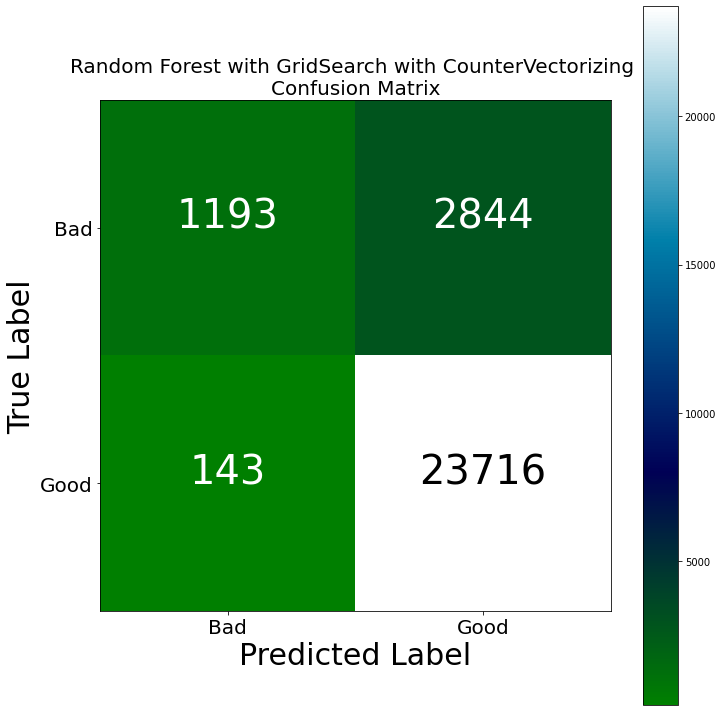

In [76]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest with GridSearch")

In [56]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.8954579176780376


In [57]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      4037
           1       0.95      0.93      0.94     23859

    accuracy                           0.89     27896
   macro avg       0.78      0.81      0.79     27896
weighted avg       0.90      0.89      0.90     27896



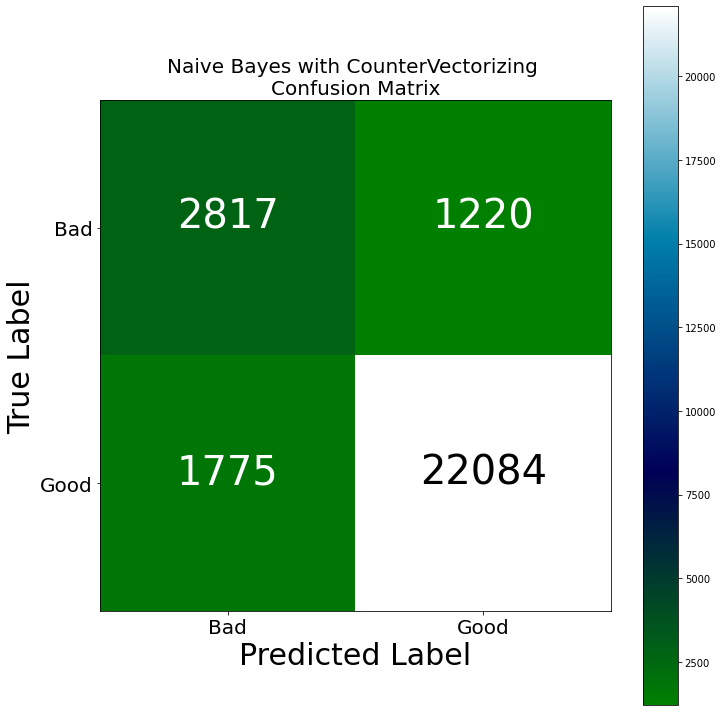

In [58]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

In [62]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

c:\users\dfota\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.9013023811836038


In [63]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.80      0.51      0.62      4037
           1       0.92      0.98      0.95     23859

    accuracy                           0.91     27896
   macro avg       0.86      0.74      0.78     27896
weighted avg       0.90      0.91      0.90     27896



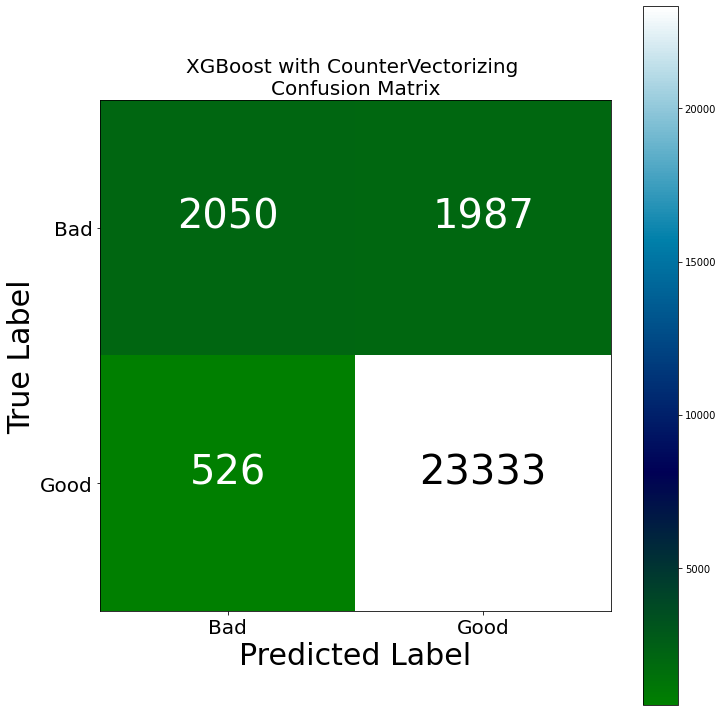

In [64]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

In [34]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), max_features=10000)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [35]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'sag', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8864433356650955


In [36]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.54      0.88      0.67      4059
           1       0.98      0.87      0.92     23837

    accuracy                           0.88     27896
   macro avg       0.76      0.88      0.80     27896
weighted avg       0.91      0.88      0.89     27896



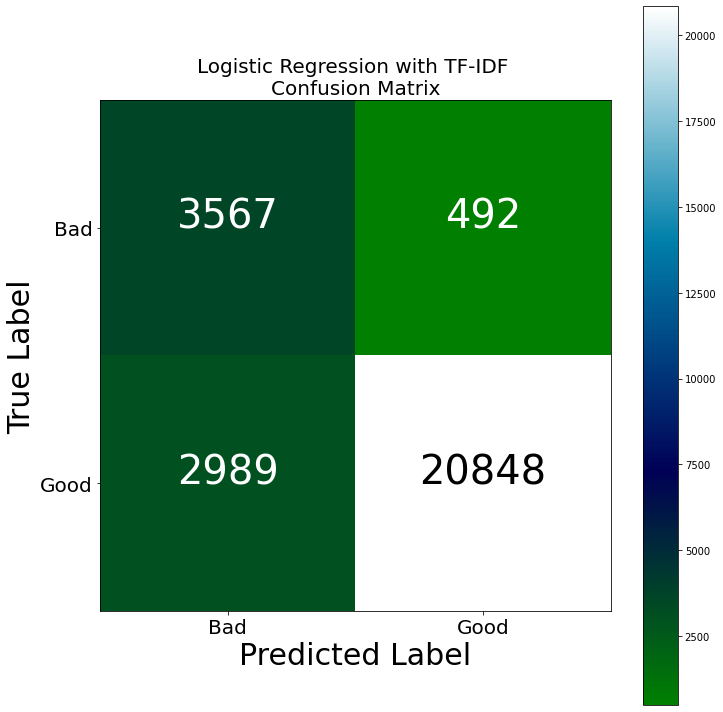

In [37]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

In [59]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 100, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.8696807024793944


In [60]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.93      0.29      0.45      4059
           1       0.89      1.00      0.94     23837

    accuracy                           0.89     27896
   macro avg       0.91      0.65      0.69     27896
weighted avg       0.90      0.89      0.87     27896



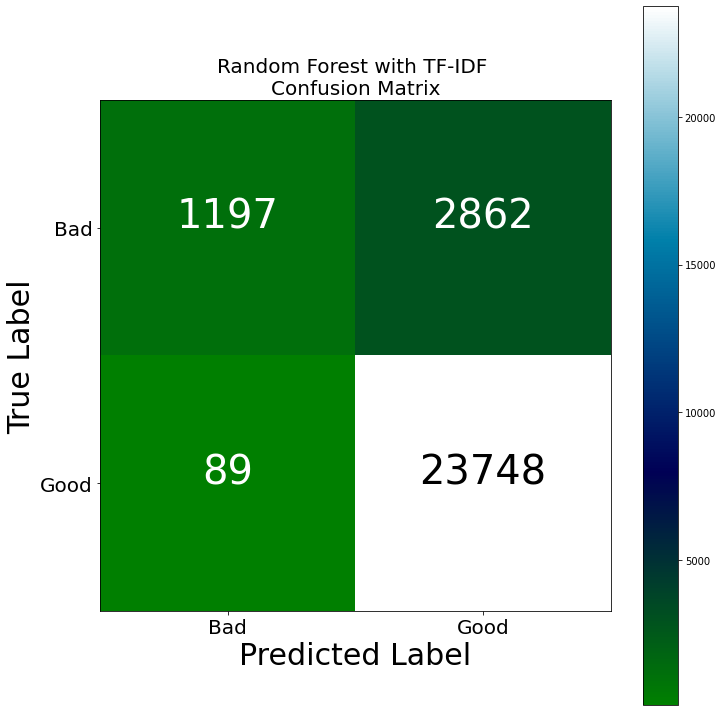

In [61]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

In [38]:
n_estimators = [10, 25, 50]

In [39]:
param_grid = dict(n_estimators=n_estimators)

In [40]:
dfrst = RandomForestClassifier(n_estimators=n_estimators)

In [41]:
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid)

In [42]:
grid_results = grid.fit(tfidf_vect_train, y_train)

In [49]:
grid_results.best_params_

{'n_estimators': 50}

In [50]:
n_estimators = [50, 100, 200]

In [51]:
param_grid = dict(n_estimators=n_estimators)

In [52]:
dfrst = RandomForestClassifier(n_estimators=n_estimators)

In [53]:
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid)

In [54]:
grid_results = grid.fit(tfidf_vect_train, y_train)

In [55]:
grid_results.best_params_

{'n_estimators': 50}

In [43]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.847955720087893


In [44]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.91      0.21      0.34      4059
           1       0.88      1.00      0.93     23837

    accuracy                           0.88     27896
   macro avg       0.89      0.60      0.64     27896
weighted avg       0.88      0.88      0.85     27896



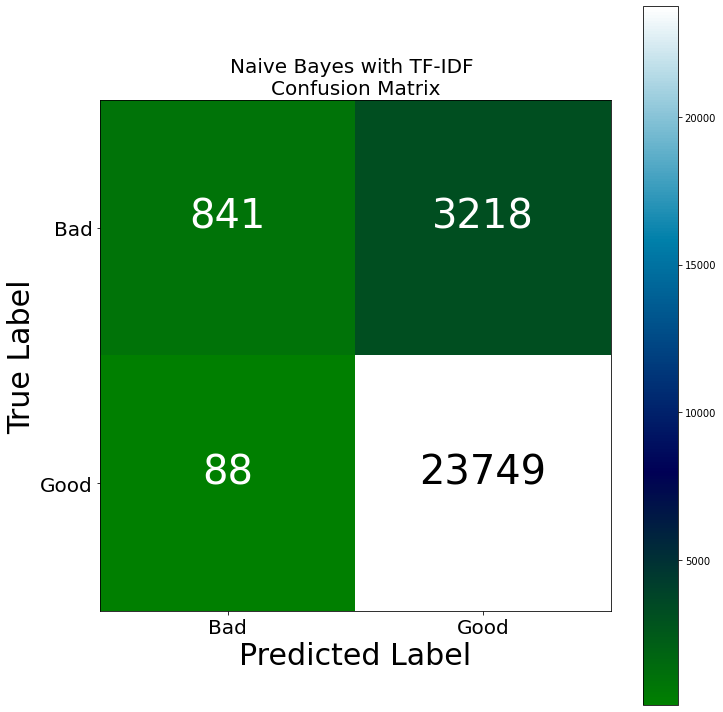

In [45]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

In [46]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

[20:41:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.9046397390533396


In [47]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.81      0.52      0.64      4059
           1       0.92      0.98      0.95     23837

    accuracy                           0.91     27896
   macro avg       0.87      0.75      0.79     27896
weighted avg       0.91      0.91      0.90     27896



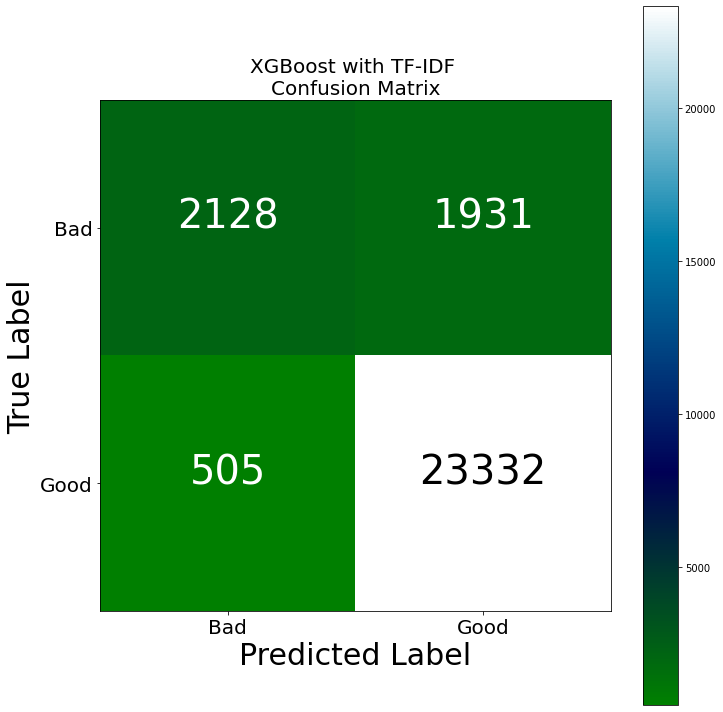

In [48]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")